In [ ]:
# !pip3 install bdateutil

In [2]:
from pandas import Timestamp
# from bdateutil import isbday
# import holidays
import numpy as np
import pandas as pd 
import mlfinlab as ml
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import BDay




# Utils (skip over this)

In [3]:
def generate_diagnostic_frame(dataset, iloc, roll_dates):

    diag_df = pd.DataFrame({})
    diag_df['last_on_termination_date'] = dataset['PX_LAST'].iloc[iloc].index
    diag_df['last_prices'] = dataset['PX_LAST'].iloc[iloc].values
    diag_df['open_day_after_termination_date'] = roll_dates
    diag_df['open_prices'] = dataset['PX_OPEN'].loc[roll_dates].values

    diag_df['gap'] = dataset['PX_OPEN'].loc[roll_dates].values - dataset['PX_LAST'].iloc[iloc].values

    return diag_df


def shift_by(n_days, price_df):
    price_series = pd.DataFrame()
    indexed_list = list(price_df['dates'])
    indexed_list = [indexed_list.index(i)-n_days for i in price_df['first_day_month'].dropna()]
    price_series['expiry'] = price_df.iloc[indexed_list]['dates']
    return price_series

def set_target_expiry_date(price_df):
    price_series = pd.DataFrame()
    price_series['dates'] = price_df.index
    price_series['expiry_month'] = price_df.index.to_period('M')  
    price_series['day'] = price_df.index.to_period('D').day
    price_series['min_day'] = price_series.groupby(by=['expiry_month'])['day'].transform(min)
    price_series['first_day_month'] = price_series['expiry_month'].astype(str) + "-" + price_series['min_day'].astype(str)
    price_series['first_day_month'] = pd.to_datetime(price_series['first_day_month'], errors='coerce')
    return price_series


def is_expiry_busines_day(price_series, col):

    business_day = []
    for roll_date in price_series[col]:
        business_day.append( False) # isbday( str(roll_date), holidays = holidays.US() ) )

    price_series['is_bday'] = business_day
    return price_series


def set_target_twnfif_expiry_date(price_df):
    price_series = pd.DataFrame()
    price_series['dates'] = price_df.index
    price_series['expiry_month'] = price_df.index.to_period('M')
    price_series['day'] = price_df.index.to_period('D').day
    price_series['min_day'] = 25
    price_series['25_day_month'] = price_series['expiry_month'].astype(str) + "-" + price_series['min_day'].astype(str)
    price_series['25_day_month'] = pd.to_datetime(price_series['25_day_month'], errors='coerce')
    return price_series 

def get_date_of_index(dataset, idx, days_prior):
    # Get specific Year-Month delta, ex. 1995-12
    specific_working_month_delta = idx.to_period('M')
    
    # Use previous delta to get all days in that month from the original series.
    full_working_month = dataset.loc[pd.to_datetime(dataset.index).to_period('M') == specific_working_month_delta]

    # Remove all days including and after 25 days
    full_working_month = full_working_month[full_working_month.index.day < 25]

    # Get Bottom 3 days and select the first one of them
    return full_working_month.last(str(days_prior) + 'd').first('d').index


def set_target_expiry_date_first_day(price_df):
    price_series = pd.DataFrame({})
    price_series['dates'] = price_df.index.values
    price_series['expiry_month'] = price_df.index.to_period('M') #price_series.index + pd.offsets.MonthBegin() 
    price_series['day'] = price_df.index.to_period('D').day
    price_series['min_day'] = price_series.groupby(by=['expiry_month'])['day'].transform(min)
    price_series['first_day_month'] = price_series['expiry_month'].astype(str) + "-" + price_series['min_day'].astype(str)
    price_series['first_day_month'] = pd.to_datetime(price_series['first_day_month'], errors='coerce')
    return price_series#.dropna()


# CRUDE WTI

In [4]:
cl_df = pd.read_csv('./data/CL.csv')
cl_df['Dates'] = pd.to_datetime(cl_df['Dates'])
cl_df.dropna(inplace=True)
cl_df.index = cl_df['Dates']

In [5]:
def forward_roll_wti(dataset):
    
    ## Trying to Replicate: 
    # Trading terminates 3 business day prior to the 25th calendar day of the month prior to the contract
    # month. If the 25th calendar day is not a business day, trading terminates 4 business days prior to 
    # the 25th calendar day of the month prior to the contract month.
    
    # Get all monthly 25ths in the date range specified in the dataset 
    cl_final_df = set_target_twnfif_expiry_date(dataset)

    # cl_final_df = is_expiry_busines_day(cl_final_df, '25_day_month')

    # Remove duplicate dates from the list
    twnty_fives = cl_final_df['25_day_month'].drop_duplicates()

    working_frame = is_expiry_busines_day(pd.DataFrame(twnty_fives), '25_day_month')[:-1]
    working_frame['is_in_original_index'] = pd.Series(twnty_fives.isin(cl_final_df['dates']))
    
    # Diagnostic check; How many 25ths are business days?
    # (True: 204, False: 118, Name: is_businessday, dtype: int64)
    
    # Diagnostic check; How many 25ths actually occur in the dataset?
    # (True: 230, False: 92, Name: is_in_original_index, dtype: int64)
    
    # working_frame['is_bday'].value_counts(), working_frame['is_in_original_index'].value_counts()

    # CRITICAL ASSUMPTION HERE :
    # ALL HOLIDAYS SHOULD HAVE NO PRICING DATA BECAUSE IT'S A HOLIDAY 
    
    futures_df_index = list(dataset.index)
    
    # Get all 25ths that have occured (ie. have price data), and get 2 days prior to them.
    roll_over_dates_for_business_days = [futures_df_index.index(i)-2 for i in working_frame
                                    [working_frame['is_in_original_index'] == True]['25_day_month'].values]
    
    # DIAGNOSIS PRINT:
    # futures_prices_df.iloc[roll_over_dates_for_non_holidays].index.values
    
    # Get all 25ths that did not occur (ie. they were holidays so no price data for that day).
    roll_over_dates_on_holidays = working_frame[working_frame['is_in_original_index'] == False]['25_day_month']

    roll_over_dates_for_holidays = []

    # Get x business days prior to (non business day) 25th that are available in the dataset. 
    for rodh in roll_over_dates_on_holidays:
        roll_over_dates_for_holidays.append( get_date_of_index(dataset, rodh, 3).values )

    roll_over_dates_for_holidays = np.ravel(roll_over_dates_for_holidays)
    
    # DIAGNOSIS PRINT:
    # roll_over_dates_for_holidays    
    
    all_roll_overs =pd.concat([ pd.Series(roll_over_dates_for_holidays),
                          pd.Series(dataset.iloc[roll_over_dates_for_business_days].index.values) ])
    
    # DIAGNOSIS PRINT:
    # is_expiry_busines_day(pd.DataFrame(all_roll_overs, 
    #                         columns=['roll_over_dates']), 'roll_over_dates')['is_bday'].value_counts()
    
    rollDates = all_roll_overs.sort_values().values
    gaps = dataset['PX_LAST']*0
    iloc=list(dataset.index)
    iloc = [iloc.index(i)-1 for i in rollDates]
    gaps.loc[rollDates] = dataset['PX_OPEN'].loc[rollDates] - dataset['PX_LAST'].iloc[iloc].values

    gaps = gaps.cumsum().dropna()

    gaps -= gaps.iloc[-1]

    return gaps, generate_diagnostic_frame(dataset, iloc, rollDates)

In [6]:
wti_gaps, wti_diag_frame = forward_roll_wti(cl_df)

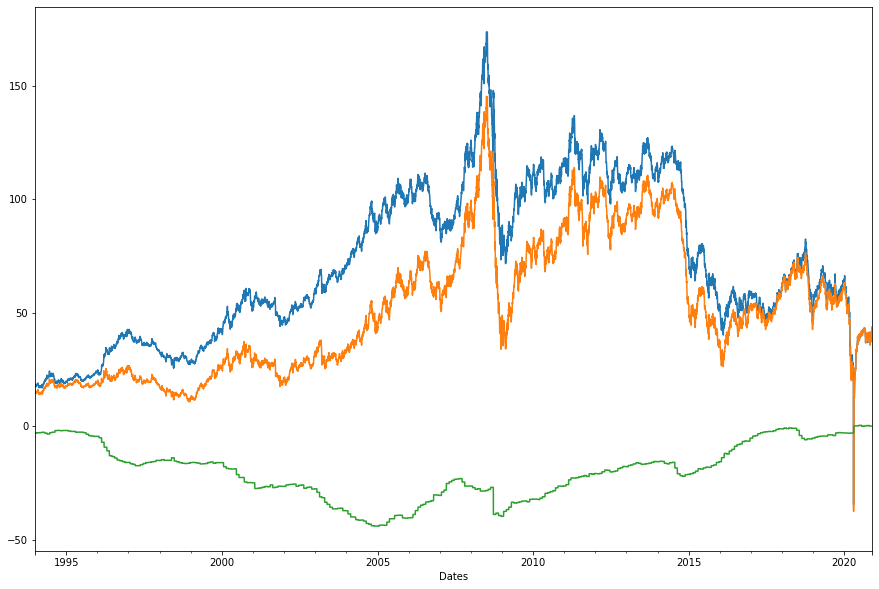

In [7]:
(cl_df['PX_LAST'] - wti_gaps).plot(figsize=(15,10))
cl_df['PX_LAST'].plot()
wti_gaps.plot()

In [8]:
wti_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,1994-01-20,15.10,1994-01-21,15.27,0.17
1,1994-02-22,14.24,1994-02-23,14.30,0.06
2,1994-03-22,15.20,1994-03-23,15.35,0.15
3,1994-04-20,16.82,1994-04-21,16.46,-0.36
4,1994-05-20,18.92,1994-05-23,18.50,-0.42
5,1994-06-21,20.04,1994-06-22,20.65,0.61
6,1994-07-20,19.20,1994-07-21,19.42,0.22
7,1994-08-22,16.87,1994-08-23,17.58,0.71
8,1994-09-20,17.24,1994-09-21,17.31,0.07
9,1994-10-20,17.54,1994-10-21,17.41,-0.13


In [9]:
wti_diag_frame.sort_values('gap').head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
176,2008-09-22,120.92,2008-09-23,108.98,-11.94
247,2014-08-20,96.07,2014-08-21,93.49,-2.58
77,2000-06-20,33.05,2000-06-21,30.52,-2.53
84,2001-01-22,32.19,2001-01-23,29.69,-2.50
246,2014-07-22,104.42,2014-07-23,101.96,-2.46
294,2018-07-20,70.46,2018-07-23,68.17,-2.29
26,1996-03-20,23.06,1996-03-21,20.90,-2.16
28,1996-05-21,22.65,1996-05-22,20.50,-2.15
111,2003-04-22,29.91,2003-04-23,27.90,-2.01
109,2003-02-20,36.79,2003-02-21,34.80,-1.99


# NBP UK Gas

Trading will cease at the close of business two Business Days prior to the first calendar day of the delivery month, quarter, season, or calendar.

In [10]:
nbp_df = pd.read_csv('./data/NBP.csv')
nbp_df['Dates'] = pd.to_datetime(nbp_df['Dates'])
nbp_df.set_index('Dates', inplace=True)

In [11]:

def roll_forward_nbp(dataset):
    
    final_df = set_target_expiry_date(dataset)
    final_df = shift_by(1, final_df)
    
    nbp_roll_dates = final_df['expiry'].drop_duplicates().dropna().values[:-1]
    
    gaps = dataset['PX_LAST']*0
    iloc=list(dataset.index)
    iloc = [iloc.index(i)-1 for i in nbp_roll_dates]
    gaps.loc[nbp_roll_dates] = dataset['PX_OPEN'].loc[nbp_roll_dates] - dataset['PX_LAST'].iloc[iloc].values

    gaps = gaps.cumsum().dropna()

    gaps -= gaps.iloc[-1]

    return gaps, generate_diagnostic_frame(dataset, iloc, nbp_roll_dates)


In [12]:
nbp_gaps, nbp_diag_frame = roll_forward_nbp(nbp_df)

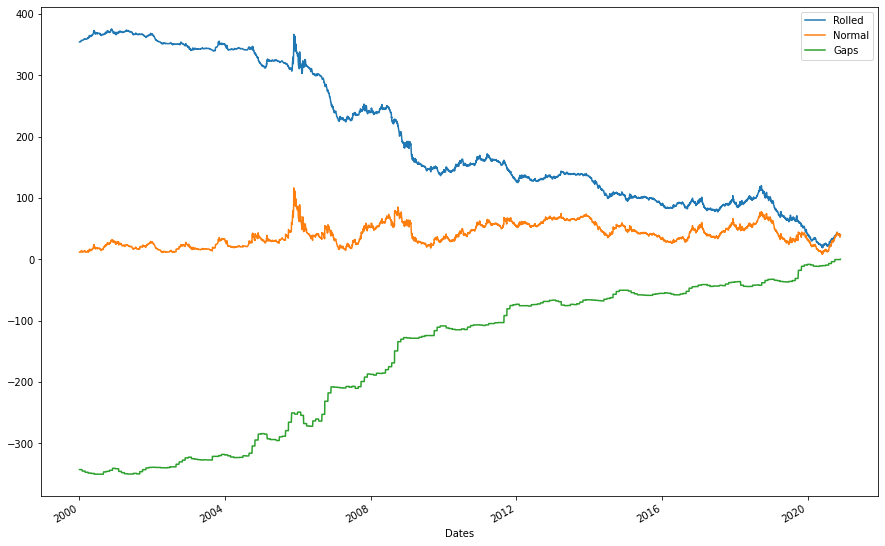

In [13]:

(nbp_df['PX_LAST'] - nbp_gaps).plot(figsize=(15,10))
nbp_df['PX_LAST'].plot()
nbp_gaps.plot()

plt.legend(["Rolled", "Normal", "Gaps"])

In [14]:
nbp_diag_frame

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,2020-11-24,39.04,2020-11-25,39.48,0.44
1,2000-01-28,13.98,2000-01-31,11.55,-2.43
2,2000-02-28,13.90,2000-02-29,12.00,-1.90
3,2000-03-30,13.10,2000-03-31,11.75,-1.35
4,2000-04-27,14.83,2000-04-28,14.20,-0.63
...,...,...,...,...,...
245,2020-05-28,8.34,2020-05-29,8.75,0.41
246,2020-06-29,15.97,2020-06-30,16.80,0.83
247,2020-07-30,13.46,2020-07-31,16.09,2.63
248,2020-08-27,24.33,2020-08-28,27.35,3.02


# RBOB

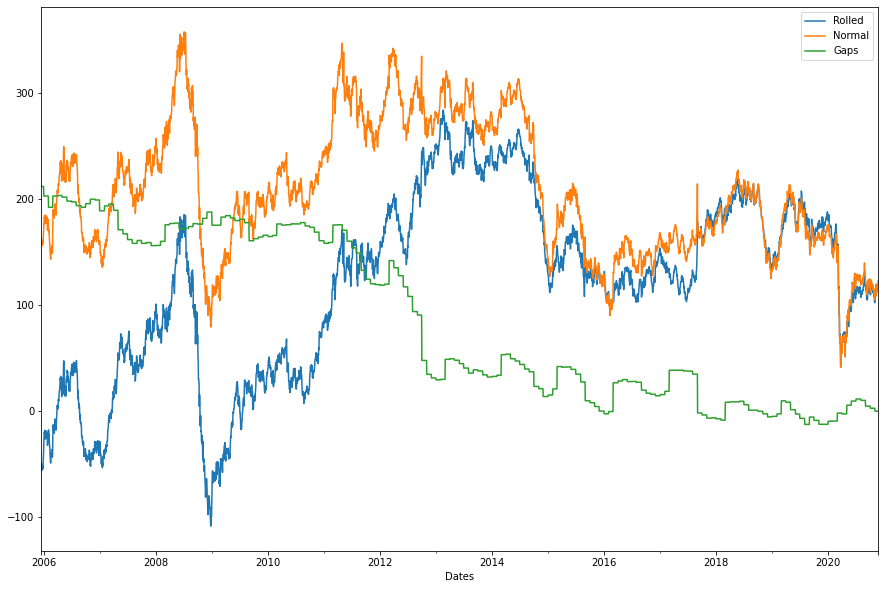

In [15]:
rb_df = pd.read_csv('./data/RB.csv').dropna()
rb_df['Dates'] = pd.to_datetime(rb_df['Dates'])
rb_df.set_index('Dates', inplace=True)

def roll_forward_rb(dataset):
    ## ASSUMING THE EXPIRATION IS THE LAST BUSINES DAY OF THE MONTH

    final_df = set_target_expiry_date_first_day(dataset)
    rb_roll_dates = final_df['first_day_month'].drop_duplicates().dropna().values[1:]#[:-1]

    gaps = dataset['PX_LAST']*0
    iloc=list(dataset.index)
    iloc = [iloc.index(i)-1 for i in rb_roll_dates]
    gaps.loc[rb_roll_dates] = dataset['PX_OPEN'].loc[rb_roll_dates] - dataset['PX_LAST'].iloc[iloc].values

    gaps = gaps.cumsum()
    gaps -= gaps.iloc[-1]
    
    return pd.Series(gaps), generate_diagnostic_frame(dataset, iloc, rb_roll_dates)


rb_gaps, rb_diag_frame = roll_forward_rb(rb_df)

(rb_df['PX_LAST'] - rb_gaps).plot(figsize=(15,10))
rb_df['PX_LAST'].plot()
rb_gaps.plot()

plt.legend(["Rolled", "Normal", "Gaps"])

In [16]:
rb_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,2005-12-30,174.00,2006-01-02,165.00,-9.00
1,2006-01-31,175.58,2006-02-01,165.00,-10.58
2,2006-02-28,154.43,2006-03-01,165.00,10.57
3,2006-03-31,206.45,2006-04-03,207.00,0.55
4,2006-04-28,221.00,2006-05-01,219.40,-1.60
5,2006-05-31,228.73,2006-06-01,225.00,-3.73
6,2006-06-30,239.31,2006-07-03,238.55,-0.76
7,2006-07-31,234.96,2006-08-01,231.50,-3.46
8,2006-08-31,182.07,2006-09-01,180.50,-1.57
9,2006-09-29,156.32,2006-10-02,159.70,3.38


# DEPRADO'S IMPLEMENTATION - FOR REFERENCE

In [17]:
# def getRolledSeries(pathIn, key):
#     series=//
#     series['Time'] = pd.to_datetime(series['Time'], format='%%%%')
#     series=series.set_index('Time')
#     gaps=rollGaps(series)
#     for fld in ['Close', 'VWAP']: 
#         series[fld] -= gaps
#     return series

# def rollGaps(series, dictio={'Instrument':'FUT_CUR_GEN_TICKER', 'Open':'PX_OPEN', 'Close':'PX_LAST'}, matchEnd=True):
#     rollDates= series[dictio['Instrument']].drop_duplicates(keep='first').index
#     gaps=series[dictio['Close']]*0
#     iloc=list(series.index)
#     iloc=[iloc.index(i)-1 for i in rollDates]
#     gaps.loc[rollDates[1:]]=series[dictio['Open']].loc[rollDates[1:]] - series[dictio['Close']].iloc[iloc[1:]].values
#     gaps=gaps.cumsum()
#     if matchEnd:
#         gaps -= gaps.iloc[-1]
#     return gaps